In [2]:
import torch
print(torch.cuda.is_available())  # Should return True


import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


True


KeyboardInterrupt: 

[]


In [3]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from datasets import load_dataset
model = TFAutoModel.from_pretrained("bert-base-uncased")

d:\Machine_Learning\NLP\Multimodal_Emotion_Recognition_System\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [4]:
import pandas as pd
#Load the dataset

df = pd.read_csv('merged_data.csv')
df

,text,label
0,i feel awful about it too because it s my job ...,sad
1,im alone i feel awful,sad
2,ive probably mentioned this before but i reall...,joyful
3,i was feeling a little low few days back,sad
4,i beleive that i am much more sensitive to oth...,love
...,...,...
493472,Yeah reminds me of the good old days. I miss ...,sentimental
493473,I woke up this morning to my wife telling me s...,surprised
493474,Oh hey that's awesome! That is awesome right?,surprised
493475,It is soooo awesome. We have been wanting a b...,surprised


In [5]:
df.shape

(493477, 2)

In [6]:
emotions_len=len(df['label'].unique())
emotions_len


34

In [7]:
df['label'].duplicated(keep=False)


0         True
1         True
2         True
3         True
4         True
          ... 
493472    True
493473    True
493474    True
493475    True
493476    True
Name: label, Length: 493477, dtype: bool

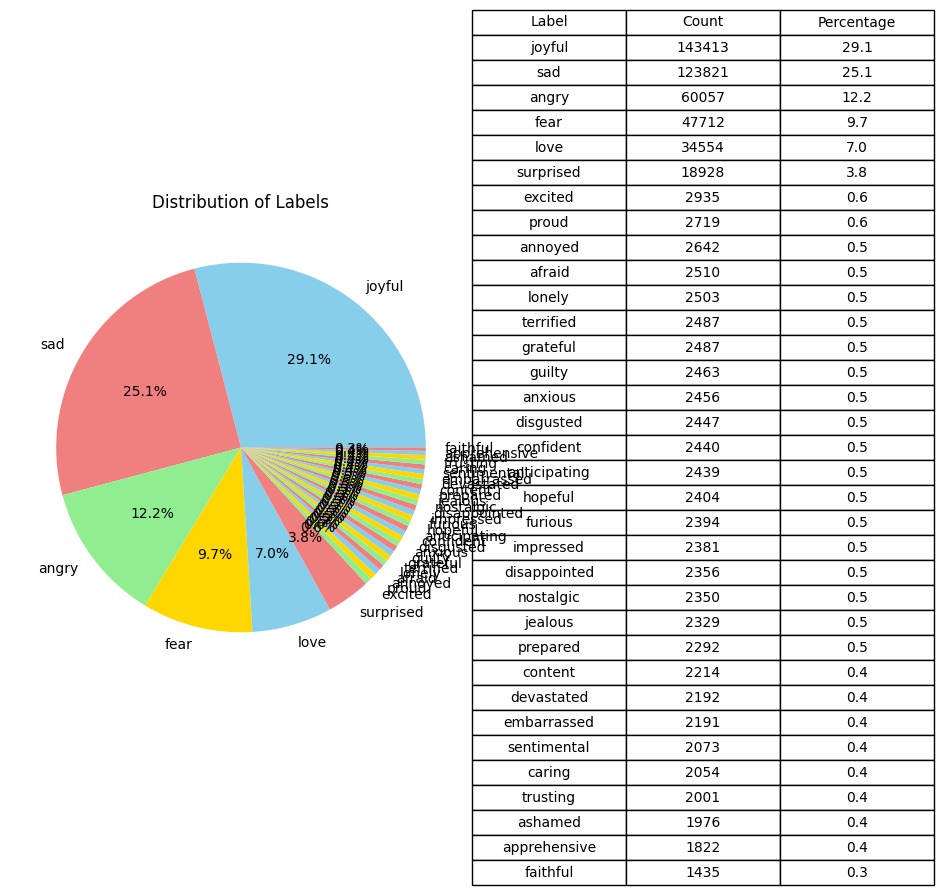

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Count values
label_counts = df['label'].value_counts()
percentages = (label_counts / label_counts.sum()) * 100  # Convert to percentage

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax.set_title("Distribution of Labels")

# Create a table
table_data = {'Label': label_counts.index, 'Count': label_counts.values, 'Percentage': percentages.round(1)}
table_df = pd.DataFrame(table_data)

# Add table to plot
table = plt.table(cellText=table_df.values, colLabels=table_df.columns, cellLoc='center', loc='right')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Show plot
plt.show()


In [9]:
import re
import string
#Preprocess text
def preprocess_text(text):
    text=text.lower()
    text=re.sub('[^a-z A-Z 0-9]','',text)
    text= text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text= re.sub(r'\d+', '', text)  # Remove numbers
    return text.strip()

In [10]:
df['text']=df['text'].apply(lambda x: preprocess_text(x))


In [11]:
df['text']

0         i feel awful about it too because it s my job ...
1                                     im alone i feel awful
2         ive probably mentioned this before but i reall...
3                  i was feeling a little low few days back
4         i beleive that i am much more sensitive to oth...
                                ...                        
493472    yeah reminds me of the good old days  i miss m...
493473    i woke up this morning to my wife telling me s...
493474          oh hey thats awesome  that is awesome right
493475    it is soooo awesome  we have been wanting a ba...
493476                      that is awesome congratulations
Name: text, Length: 493477, dtype: object

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [13]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])  # Convert labels to numeric indices

In [14]:
df['label']

0         29
1         29
2         23
3         29
4         25
          ..
493472    30
493473    31
493474    31
493475    31
493476    31
Name: label, Length: 493477, dtype: int64

In [15]:


from sklearn.model_selection import train_test_split
train_texts, test_texts = train_test_split(df, test_size=0.2, random_state=42)


In [16]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_texts)
test_dataset = Dataset.from_pandas(test_texts)

# Create DatasetDict
emotions = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [17]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 394781
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 98696
    })
})

In [ ]:
def tokenize(batch):
    encoding = tokenizer(batch["text"],  truncation=True,padding=True,max_length=128)
    return encoding


In [27]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=64)

Map:   0%|          | 0/394781 [00:00<?, ? examples/s]

Map: 100%|██████████| 98696/98696 [00:05<00:00, 19308.93 examples/s]


In [31]:
train_features = {
    'input_ids': emotions_encoded['train']['input_ids'],
    'attention_mask': emotions_encoded['train']['attention_mask']
}
train_labels = emotions_encoded['train']['label']
train_features['input_ids'][0]

<tf.Tensor: shape=(49,), dtype=int64, numpy=
array([  101, 10047,  3110,  2061, 17203,  2157,  2085,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])>

In [ ]:
train_features['input_ids'][0]

In [29]:
emotions_encoded.set_format('tf', 
                            columns=['input_ids', 'attention_mask', 'label'])

# setting BATCH_SIZE to 64.
BATCH_SIZE = 64

def order(inputs, labels):
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }, labels



train_features = {
    'input_ids': emotions_encoded['train']['input_ids'],
    'attention_mask': emotions_encoded['train']['attention_mask']
}
train_labels = emotions_encoded['train']['label']
test_features = {
    'input_ids': emotions_encoded['test']['input_ids'],
    'attention_mask': emotions_encoded['test']['attention_mask']
}
test_labels = emotions_encoded['test']['label']


# converting train split of `emotions_encoded` to tensorflow format
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))

train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)



# # ... doing the same for test set ...
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)


In [30]:
inp, out = next(iter(train_dataset)) # a batch from train_dataset
print(inp, '\n\n', out)


{'input_ids': <tf.RaggedTensor [[101, 2106, 2017, 2131, 2718, 2026, 2009, 1045, 6655, 2008, 2001, 12459,
  102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                             ,
 [101, 2821, 2054, 2079, 2017, 2079, 2005, 2008, 102, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0]                                                      ,
 [101, 1045, 3246, 2057, 2156, 4080, 1998, 1996, 20005, 2015, 2153, 2021,
  2009, 5683, 21888, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                        ,
 [101, 1045, 2356, 2026, 3611, 2000, 2377, 3455, 2007, 2033, 7483, 1045,
  9471, 2008, 2002, 2109, 2000, 2377, 2012, 1037, 2200, 2152, 2504, 1998,
  3786, 2033, 6649, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0]                                               

In [ ]:
class BERTForClassification(tf.keras.Model):
    
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

In [72]:
classifier = BERTForClassification(model, num_classes=emotions_len)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
history = classifier.fit(
    train_dataset,
    epochs=3
)

Epoch 1/3


   8/3085 [..............................] - ETA: 25:28:22 - loss: 3.3333 - accuracy: 0.1807

Epoch 1/3


ValueError: in user code:

    File "d:\Machine_Learning\NLP\Multimodal_Emotion_Recognition_System\venv\Lib\site-packages\tf_keras\src\engine\training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "d:\Machine_Learning\NLP\Multimodal_Emotion_Recognition_System\venv\Lib\site-packages\tf_keras\src\engine\training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Machine_Learning\NLP\Multimodal_Emotion_Recognition_System\venv\Lib\site-packages\tf_keras\src\engine\training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "d:\Machine_Learning\NLP\Multimodal_Emotion_Recognition_System\venv\Lib\site-packages\tf_keras\src\engine\training.py", line 1147, in train_step
        y_pred = self(x, training=True)
    File "d:\Machine_Learning\NLP\Multimodal_Emotion_Recognition_System\venv\Lib\site-packages\tf_keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filepv9qn7kx.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).bert, (ag__.ld(inputs),), None, fscope)[1]
    File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filemy0q7odf.py", line 34, in tf__run_call_with_unpacked_inputs
        unpacked_inputs = ag__.converted_call(ag__.ld(input_processing), (ag__.ld(func), ag__.ld(config)), dict(**ag__.ld(fn_args_and_kwargs)), fscope)
    File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 296, in tf__input_processing
        ag__.if_stmt(ag__.converted_call(ag__.ld(isinstance), (ag__.ld(main_input), (ag__.ld(tuple), ag__.ld(list))), None, fscope), if_body_16, else_body_16, get_state_19, set_state_19, ("output['input_ids']", "output['past_key_values']", 'output[main_input_name]'), 3)
    File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 291, in else_body_16
        ag__.if_stmt(ag__.converted_call(ag__.ld(isinstance), (ag__.ld(main_input), ag__.ld(Mapping)), None, fscope), if_body_15, else_body_15, get_state_18, set_state_18, ("output['input_ids']", "output['past_key_values']", 'output[main_input_name]'), 3)
    File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 274, in if_body_15
        ag__.for_stmt(ag__.converted_call(ag__.converted_call(ag__.ld(dict), (ag__.ld(main_input),), None, fscope).items, (), None, fscope), None, loop_body_2, get_state_16, set_state_16, (), {'iterate_names': '(k, v)'})
    File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 272, in loop_body_2
        ag__.if_stmt(ag__.or_(lambda: ag__.converted_call(ag__.ld(isinstance), (ag__.ld(v), ag__.ld(allowed_types)), None, fscope), lambda: ag__.ld(v) is None), if_body_13, else_body_13, get_state_15, set_state_15, ('output[k]',), 1)
    File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 271, in else_body_13
        ag__.if_stmt(ag__.and_(lambda: ag__.ld(k) not in ag__.ld(parameter_names), lambda: 'args' not in ag__.ld(parameter_names)), if_body_12, else_body_12, get_state_14, set_state_14, (), 0)
    File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 270, in else_body_12
        raise ag__.converted_call(ag__.ld(ValueError), (f'Data of type {ag__.converted_call(ag__.ld(type), (ag__.ld(v),), None, fscope)} is not allowed only {ag__.ld(allowed_types)} is accepted for {ag__.ld(k)}.',), None, fscope)

    ValueError: Exception encountered when calling layer 'bert_for_classification_1' (type BERTForClassification).
    
    in user code:
    
        File "C:\Users\GITESH\AppData\Local\Temp\ipykernel_27776\1789570677.py", line 9, in call  *
            x = self.bert(inputs)[1]
        File "d:\Machine_Learning\NLP\Multimodal_Emotion_Recognition_System\venv\Lib\site-packages\tf_keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filemy0q7odf.py", line 34, in tf__run_call_with_unpacked_inputs
            unpacked_inputs = ag__.converted_call(ag__.ld(input_processing), (ag__.ld(func), ag__.ld(config)), dict(**ag__.ld(fn_args_and_kwargs)), fscope)
        File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 296, in tf__input_processing
            ag__.if_stmt(ag__.converted_call(ag__.ld(isinstance), (ag__.ld(main_input), (ag__.ld(tuple), ag__.ld(list))), None, fscope), if_body_16, else_body_16, get_state_19, set_state_19, ("output['input_ids']", "output['past_key_values']", 'output[main_input_name]'), 3)
        File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 291, in else_body_16
            ag__.if_stmt(ag__.converted_call(ag__.ld(isinstance), (ag__.ld(main_input), ag__.ld(Mapping)), None, fscope), if_body_15, else_body_15, get_state_18, set_state_18, ("output['input_ids']", "output['past_key_values']", 'output[main_input_name]'), 3)
        File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 274, in if_body_15
            ag__.for_stmt(ag__.converted_call(ag__.converted_call(ag__.ld(dict), (ag__.ld(main_input),), None, fscope).items, (), None, fscope), None, loop_body_2, get_state_16, set_state_16, (), {'iterate_names': '(k, v)'})
        File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 272, in loop_body_2
            ag__.if_stmt(ag__.or_(lambda: ag__.converted_call(ag__.ld(isinstance), (ag__.ld(v), ag__.ld(allowed_types)), None, fscope), lambda: ag__.ld(v) is None), if_body_13, else_body_13, get_state_15, set_state_15, ('output[k]',), 1)
        File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 271, in else_body_13
            ag__.if_stmt(ag__.and_(lambda: ag__.ld(k) not in ag__.ld(parameter_names), lambda: 'args' not in ag__.ld(parameter_names)), if_body_12, else_body_12, get_state_14, set_state_14, (), 0)
        File "C:\Users\GITESH\AppData\Local\Temp\__autograph_generated_filevwywabok.py", line 270, in else_body_12
            raise ag__.converted_call(ag__.ld(ValueError), (f'Data of type {ag__.converted_call(ag__.ld(type), (ag__.ld(v),), None, fscope)} is not allowed only {ag__.ld(allowed_types)} is accepted for {ag__.ld(k)}.',), None, fscope)
    
        ValueError: Exception encountered when calling layer 'tf_bert_model' (type TFBertModel).
        
        in user code:
        
            File "d:\Machine_Learning\NLP\Multimodal_Emotion_Recognition_System\venv\Lib\site-packages\transformers\modeling_tf_utils.py", line 1181, in run_call_with_unpacked_inputs  *
                unpacked_inputs = input_processing(func, config, **fn_args_and_kwargs)
            File "d:\Machine_Learning\NLP\Multimodal_Emotion_Recognition_System\venv\Lib\site-packages\transformers\modeling_tf_utils.py", line 561, in input_processing  *
                raise ValueError(f"Data of type {type(v)} is not allowed only {allowed_types} is accepted for {k}.")
        
            ValueError: Data of type <class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.
        
        
        Call arguments received by layer 'tf_bert_model' (type TFBertModel):
          • input_ids={'input_ids': 'tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=int64), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int32))', 'attention_mask': 'tf.RaggedTensor(values=Tensor("RaggedFromVariant/RaggedTensorFromVariant:1", shape=(None,), dtype=int64), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(None,), dtype=int32))'}
          • attention_mask=None
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=None
          • output_attentions=None
          • output_hidden_states=None
          • return_dict=None
          • training=True
    
    
    Call arguments received by layer 'bert_for_classification_1' (type BERTForClassification):
      • inputs={'input_ids': 'tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=int64), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int32))', 'attention_mask': 'tf.RaggedTensor(values=Tensor("RaggedFromVariant/RaggedTensorFromVariant:1", shape=(None,), dtype=int64), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(None,), dtype=int32))'}
